<a href="https://colab.research.google.com/github/gagoorisamchon/aalto/blob/main/aifinance_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요한 모듈을 임포트 한다.

In [38]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss, coint
import yfinance as yf

Yahoo finance에서 코스피지수와 삼성전자 주가를 읽어온다.

In [11]:
tickers = [ "^KS11", "005935.KS"]
names = [ "KOSPI", "SAMSUNG"]
start_date = "2018-01-01"
end_date = "2022-12-31"

df = pd.DataFrame()

for ticker in tickers:
  df[ticker] = yf.download(ticker, start_date, end_date, progress=False).Close

df.columns = names
df.head()


,KOSPI,SAMSUNG
Date,,
2018-01-02,2479.649902,41940.0
2018-01-03,2486.350098,41800.0
2018-01-04,2466.459961,41800.0
2018-01-05,2497.520020,42260.0
2018-01-08,2513.280029,42060.0


삼성전자 주가를 도식화 해 본다.

<Axes: xlabel='Date'>

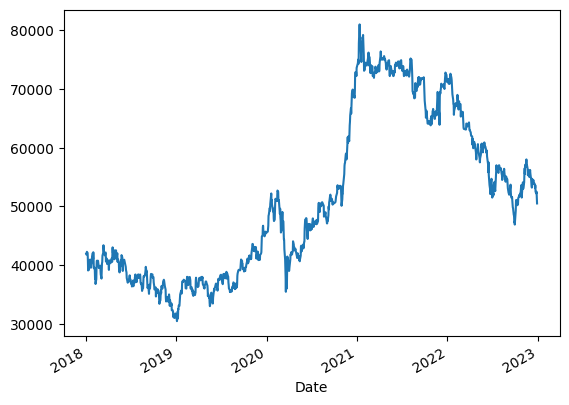

In [13]:
df['SAMSUNG'].plot()

삼성주가의 ADF 검정의 p-값을 구해 본다.

In [26]:
result_ss = pd.Series( adfuller(df['SAMSUNG'])[0:4] )
print("p값=", result_ss[1], " 임계치=", result_ss[0])

p값= 0.6860551720029808  임계치= -1.170737962116687


비정상성이라는 것이 확인되었다. 이제 차분(difference)을 통해 정상성이 생기는지 보자.
먼저 수익률을 구하고 이를 도식화 해보자.

<Axes: xlabel='Date'>

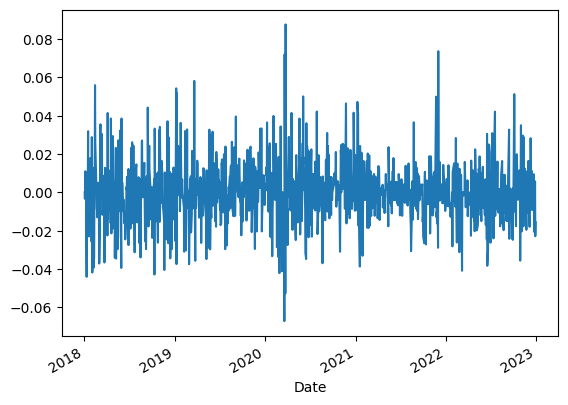

In [59]:
pct_ss_diff = df['SAMSUNG'].pct_change().fillna(0)
pct_ss_diff.plot()

수익률의 ADF-검정을 하고 p값을 구해 본다.

In [60]:
result_ss_diff = pd.Series( adfuller(pct_ss_diff)[0:4] )
print("p값=", result_ss_diff[1], " 임계치=", result_ss_diff[0])

p값= 7.271176286425393e-30  임계치= -17.11965755843526


코스피 지수를 그림을 그려본다.

<Axes: xlabel='Date'>

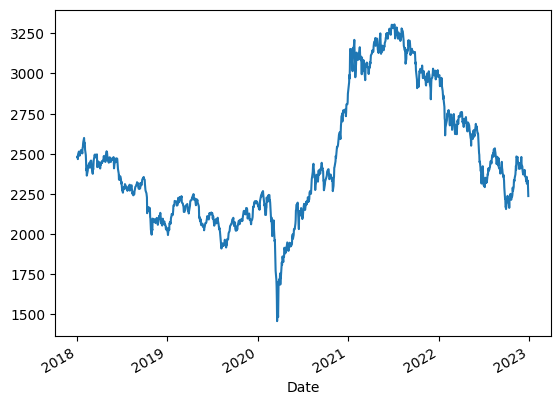

In [30]:
df['KOSPI'].plot()

코스피지수의 ADF 검정의 p-값을 구해 본다.

In [61]:
result_ko = pd.Series( adfuller(df['KOSPI'])[0:4] )
print("p값=", result_ko[1], " 임계치=", result_ko[0])

p값= 0.6448814008475783  임계치= -1.2653289246410853


비정상성이라는 것이 확인되었다. 이제 차분(difference)을 통해 정상성이 생기는지 보자. 먼저 수익률을 구하고 이를 도식화 해보자.

<Axes: xlabel='Date'>

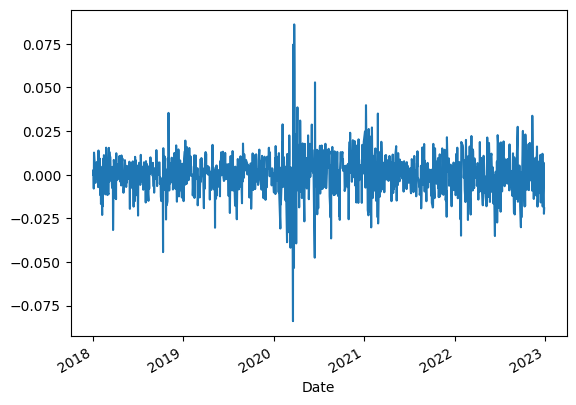

In [62]:
pct_ko_diff = df['KOSPI'].pct_change().fillna(0)
pct_ko_diff.plot()

수익률의 ADF-검정을 하고 p값을 구해 본다.

In [65]:
result_ko_diff = pd.Series( adfuller(pct_ko_diff)[0:4] )
print("p값=", result_ko_diff[1], " 임계치=", result_ko_diff[0])

p값= 0.0  임계치= -21.913549902920074


# 공적분 검정

공적분을 검정한 결과 p-값을 저장하기 위한 2차원 행렬을 생성한다.
p-값이 0.05 이하(95%신뢰)이면 공적분이므로, 초기값은 모두 1로 한다.

In [40]:
p_values = np.ones( (len(names), len(names)) )

루프를 돌며, 공적분을 계산하고 그 p-값을 2차원 배열에 저장한다.

In [41]:
for i in range(0, len(names)):
  for j in range(i+1, len(names)):
    p_values[i][j] = coint( df[names[i]], df[names[j]] )[1]

루프를 돌며, 공적분 관계가 있으면(p < 0.05) 출력한다.

In [42]:
for i in range(0, len(names)):
  print("\n----------------------- ")
  print(f"{names[i]}와 공적분 관계")

  for k in range(i+1, len(names)):
    if( p_values[i][k] < 0.05 ): #공적분 관계
      print( f"[ {names[k]} , {p_values[i][k]}]", end=" "  )

  for j in range(0, i):
    if( p_values[j][i] < 0.05 ): #공적분 관계
      print( f"[ {names[j]} , {p_values[j][i] } ]", end=" "   )


----------------------- 
KOSPI와 공적분 관계

----------------------- 
SAMSUNG와 공적분 관계


In [53]:
p_values = coint(df['KOSPI'], df['SAMSUNG'])

In [54]:
print(p_values)

(-1.9626354615768018, 0.5479375073534611, array([-3.90537343, -3.34110612, -3.04790274]))


P value가 5%보다 크므로(0.5479...) 귀무가설(서로 공적분 관계가 없다.) 채택. 따라서, 삼성주가와 KOSP지수는 서로 관련성이 없다.

# 하지만, 차분을 한 데이터로 검정을 해보자.  

In [64]:
p_values_diff = coint(pct_ss_diff, pct_ko_diff)
print(p_values_diff)

(-18.52136760279348, 1.4100314508075143e-29, array([-3.90537343, -3.34110612, -3.04790274]))


# P value가 5%보다 작으므로(0.000...) 귀무가설(서로 공적분 관계가 없다.) 기각. 따라서, 삼성주가와 KOSP지수는 서로 관련성이 있다.

